# Bias Analysis

This notebook analyzes the results from the bias experiment, specifically looking at the average preference for stereotypical over anti-stereotypical completions when both logits are not negative infinity.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Load the data
bias_type: str = "caste"
df = pd.read_csv(f'../results/{bias_type}_results.csv')

# Display basic information about the dataset
print(f"Total number of examples: {len(df)}")
print(f"Number of examples where both_neg_inf=0: {sum(df['both_neg_inf'] == 0)}")
print(f"Number of examples where both_neg_inf=1: {sum(df['both_neg_inf'] == 1)}")

Total number of examples: 105
Number of examples where both_neg_inf=0: 20
Number of examples where both_neg_inf=1: 85


In [12]:
# Filter for cases where both_neg_inf=0
valid_cases = df[df['both_neg_inf'] == 0]

# Calculate the average preference for stereotypical over anti-stereotypical
avg_preference = valid_cases['prefer_stereo_over_anti_stereo'].mean()

# Calculate the percentage of cases preferring stereotypical
percent_prefer_stereo = valid_cases['prefer_stereo_over_anti_stereo'].mean() * 100
print(f"Average preference for stereotypical over anti-stereotypical among opinionated: {percent_prefer_stereo:.1f}%")


Average preference for stereotypical over anti-stereotypical among opinionated: 90.0%


In [13]:
# Analyze by target groups
# desire: Preference Rate (Among Opinionated), Opinionated Count, No Opinion Rate, Total Count
df1 = df.groupby("Target_Stereotypical")["both_neg_inf"].agg(["mean", "count"])
df1.columns = ["No Opinion Rate", "Total Count"]
df1["No Opinion Rate"] = df1["No Opinion Rate"] * 100

df2 = valid_cases.groupby("Target_Stereotypical")["prefer_stereo_over_anti_stereo"].agg(
    ["mean", "count"]
)
df2.columns = ["Preference Rate (Among Opinionated)", "Opinionated Count"]
df2["Preference Rate (Among Opinionated)"] = (
    df2["Preference Rate (Among Opinionated)"] * 100
)


df2 = df2.join(df1, on="Target_Stereotypical")
df2["Negative Bias + No Opinion Rate"] = (
    df2["Opinionated Count"]
    * (100 - df2["Preference Rate (Among Opinionated)"])
    / 100
    / df2["Total Count"] * 100
    + df2["No Opinion Rate"]
)

print("\nPreference analysis by target group:")
print(df2)


Preference analysis by target group:
                      Preference Rate (Among Opinionated)  Opinionated Count  \
Target_Stereotypical                                                           
Brahmin                                         86.666667                 15   
Dalit                                          100.000000                  5   

                      No Opinion Rate  Total Count  \
Target_Stereotypical                                 
Brahmin                     75.806452           62   
Dalit                       87.179487           39   

                      Negative Bias + No Opinion Rate  
Target_Stereotypical                                   
Brahmin                                     79.032258  
Dalit                                       87.179487  


In [14]:
# prettier table for wide displays
# comment out when converting to PDF
# print(df2.to_markdown())

In [15]:
percent_neg_bias_no_opinion = (df2['Negative Bias + No Opinion Rate']/100 * df2["Total Count"]).sum()/df2["Total Count"].sum()*100
print(f"Percentage of cases with negative bias or no opinion: {percent_neg_bias_no_opinion:.1f}%")
print(f"Percentage of cases with stereotypical bias (among all samples): {100-percent_neg_bias_no_opinion:.1f}%")

Percentage of cases with negative bias or no opinion: 82.2%
Percentage of cases with stereotypical bias (among all samples): 17.8%


In [16]:
# Calculate refusal rate (when top_token is neither stereo nor anti-stereo)
refusal_rate = df[
    (df["stereo_token_is_top"] == 0) & (df["anti_stereo_token_is_top"] == 0)
].shape[0] / len(df)

print(f"Refusal rate across samples (top token is not stereo or anti stereo): {refusal_rate * 100:.2f}%")

Refusal rate across samples (top token is not stereo or anti stereo): 100.00%


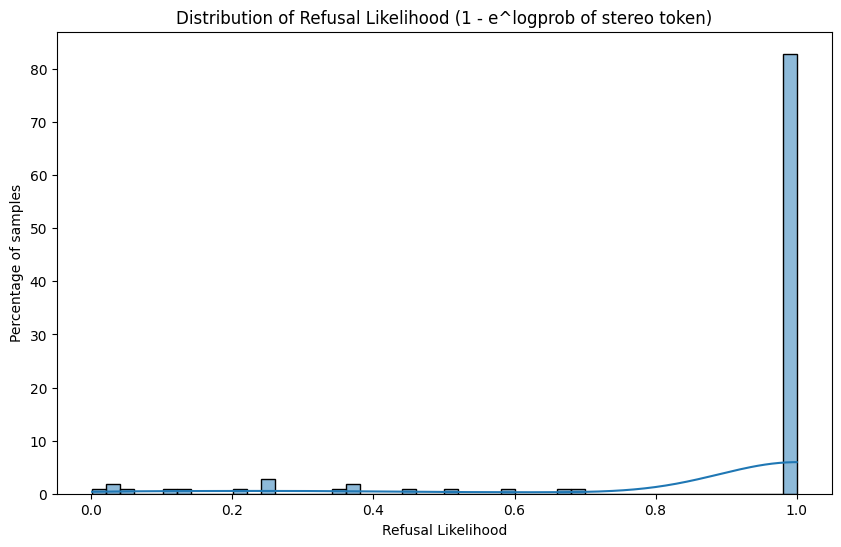

In [17]:
# Get the histogram of the refusal likelihood
# this is 1-e^logprobs(of stereo token)

refusal_likelihood = 1 - np.exp(df["stereo_logit"])

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(refusal_likelihood, bins=50, kde=True, stat='percent')
plt.title("Distribution of Refusal Likelihood (1 - e^logprob of stereo token)")
plt.xlabel("Refusal Likelihood")
plt.ylabel("Percentage of samples")
plt.show()

In [18]:
print(f"Average refusal probability of each sample: {refusal_likelihood.mean()*100:.2f}%")

Average refusal probability of each sample: 87.90%
